# import packages

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sys
sys.path.append("src/")
from src import *

2024-11-25 11:02:45.201315: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-25 11:02:45.233583: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732503765.282435  167368 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732503765.305709  167368 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-25 11:02:45.357815: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [5]:
ct = 'LA'

# load data

In [6]:
data = pd.read_parquet("data/preprocessed_data/LA/data.parquet")
prior = pd.read_parquet("data/preprocessed_data/LA/prior.parquet")

data.shape, prior.shape

((274, 10287), (186, 10287))

# raw model

In [10]:
l2_map = {}
l2_map[1.000000013351432e-10] = '1e-10'
l2_map[1.0000000116860974e-07] = '1e-07'
l2_map[9.999999747378752e-05] = '1e-04'
l2_map[0.10000000149011612] = '1e-01'

perf_raw = pd.read_csv('result_LA_no_threshold/dp1_0_dp2_0/performance.csv', index_col=0)
perf_raw['weight_decay'] = perf_raw['weight_decay'].astype(np.float32).map(l2_map)
perf_raw = perf_raw[(perf_raw['weight_decay'] == '1e-10') & (perf_raw['network_type']=='cpd')]
perf_raw.index = range(perf_raw.shape[0])

report_raw = perf_raw[['weight_decay', 'drop_p_prior', 'drop_p_kki', 'cv']].drop_duplicates().copy()
report_raw.index = range(report_raw.shape[0])

report_raw['AUPRC'] = 0.0
report_raw['R2'] = 0.0
for index, row in report_raw.iterrows():
    tmp = perf_raw.loc[(perf_raw['weight_decay']==row['weight_decay'])&\
                      (perf_raw['drop_p_prior']==row['drop_p_prior'])&\
                      (perf_raw['drop_p_kki']==row['drop_p_kki'])&\
                      (perf_raw['cv']==row['cv'])]
    # 在每个超参数组合下，每次交叉验证中，选取fit/refit（11个）模型R2最高时的AUPRC和R2作为这个超参数组合在这次交叉验证中的性能
    max_r2_row = tmp.loc[tmp['val_r2'].idxmax()]
    report_raw.at[index, 'AUPRC'] = max_r2_row['AUPRC']
    report_raw.at[index, 'R2'] = max_r2_row['val_r2']

# 计算所有交叉验证的平均值代表每个超参数组合的性能
report_raw = report_raw.groupby(['weight_decay', 'drop_p_prior', 'drop_p_kki'])[['AUPRC', 'R2']].mean().reset_index()

report_raw

,weight_decay,drop_p_prior,drop_p_kki,AUPRC,R2
0,1e-10,0,0,0.225631,0.777783


In [11]:
raw_model = torch.load('result_LA_no_threshold/dp1_0_dp2_0/model/cv4_wd9.999999999999999e-11_refit9.pth')
raw_model.eval()

KinaseNet(
  (activation): ReLU0()
  (prior): Encoder(
    (dropout): Identity()
    (activation): ReLU0()
    (fc): Linear(in_features=10287, out_features=186, bias=False)
  )
  (kki): LatentLayer(
    (dropout): Identity()
    (activation): ReLU0()
    (fc): Linear(in_features=186, out_features=186, bias=False)
  )
  (ksr): Decoder(
    (dropout): Identity()
    (activation): ReLU0()
    (fc): Linear(in_features=186, out_features=10287, bias=False)
  )
)

In [12]:
out_raw = raw_model(torch.tensor(np.array(data)).to(raw_model.prior.fc.weight.dtype)).detach().numpy()

Text(0.5, 1.0, 'Raw model')

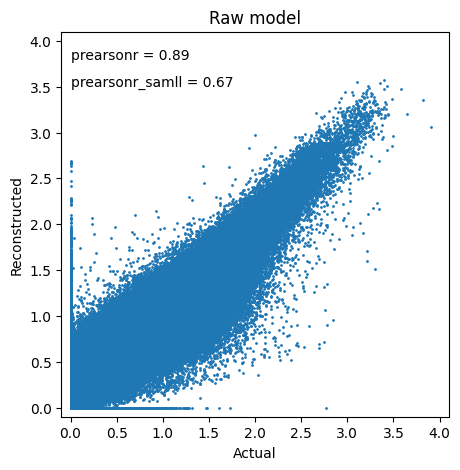

In [13]:
raw_data_flatten = np.array(data).flatten()
raw_out_flatten = out_raw.flatten()

plt.figure(figsize=(5,5))
plt.scatter(x=raw_data_flatten, y=raw_out_flatten, s=1)
plt.xlim(-0.1, 4.1)
plt.ylim(-0.1, 4.1)
plt.xlabel('Actual')
plt.ylabel('Reconstructed')
plt.text(0, 3.8, 'prearsonr = 0.89')
plt.text(0, 3.5, 'prearsonr_samll = 0.67')
plt.title('Raw model')

In [16]:
stats.pearsonr(raw_data_flatten, raw_out_flatten)

PearsonRResult(statistic=np.float64(0.8880637020624054), pvalue=np.float64(0.0))

In [17]:
stats.pearsonr(
    raw_data_flatten[raw_data_flatten < np.percentile(raw_data_flatten, 50)], 
    raw_out_flatten[raw_data_flatten < np.percentile(raw_data_flatten, 50)]
)

PearsonRResult(statistic=np.float64(0.6716777194483368), pvalue=np.float64(0.0))

# shrinkage loss model compare

In [7]:
perf_skloss = pd.read_csv('result_LA_skloss_a_10_c_0.1/dp1_0_dp2_0/performance_tmp.csv', index_col=0)
perf_skloss = perf_skloss[(perf_skloss['weight_decay'] == 1e-10) & (perf_skloss['network_type']=='cpd')]
perf_skloss.index = range(perf_skloss.shape[0])

report_skloss = perf_skloss[['weight_decay', 'drop_p_prior', 'drop_p_kki', 'cv']].drop_duplicates().copy()
report_skloss.index = range(report_skloss.shape[0])

report_skloss['AUPRC'] = 0.0
report_skloss['R2'] = 0.0
for index, row in report_skloss.iterrows():
    tmp = perf_skloss.loc[(perf_skloss['weight_decay']==row['weight_decay'])&\
                      (perf_skloss['drop_p_prior']==row['drop_p_prior'])&\
                      (perf_skloss['drop_p_kki']==row['drop_p_kki'])&\
                      (perf_skloss['cv']==row['cv'])]
    # 在每个超参数组合下，每次交叉验证中，选取fit/refit（11个）模型R2最高时的AUPRC和R2作为这个超参数组合在这次交叉验证中的性能
    max_r2_row = tmp.loc[tmp['val_r2'].idxmax()]
    report_skloss.at[index, 'AUPRC'] = max_r2_row['AUPRC']
    report_skloss.at[index, 'R2'] = max_r2_row['val_r2']
# 计算所有交叉验证的平均值代表每个超参数组合的性能
report_skloss = report_skloss.groupby(['weight_decay', 'drop_p_prior', 'drop_p_kki'])[['AUPRC', 'R2']].mean().reset_index()

report_skloss

,weight_decay,drop_p_prior,drop_p_kki,AUPRC,R2
0,1.000000e-10,0,0,0.225526,0.892796


In [8]:
mod_model_skloss = torch.load('result_LA_skloss_a_10_c_0.1/dp1_0_dp2_0/model/cv3_wd1e-10_refit9.pth')
mod_model_skloss.eval()

KinaseNet(
  (activation): ReLU0()
  (prior): Encoder(
    (dropout): Identity()
    (activation): ReLU0()
    (fc): Linear(in_features=10287, out_features=186, bias=False)
  )
  (kki): LatentLayer(
    (dropout): Identity()
    (activation): ReLU0()
    (fc): Linear(in_features=186, out_features=186, bias=False)
  )
  (ksr): Decoder(
    (dropout): Identity()
    (activation): ReLU0()
    (fc): Linear(in_features=186, out_features=10287, bias=False)
  )
)

In [14]:
out_mod_skloss = mod_model_skloss(torch.tensor(np.array(data)).to(raw_model.prior.fc.weight.dtype)).detach().numpy()

Text(0.5, 1.0, 'shrinkage loss(a = 10, c = 0.1)')

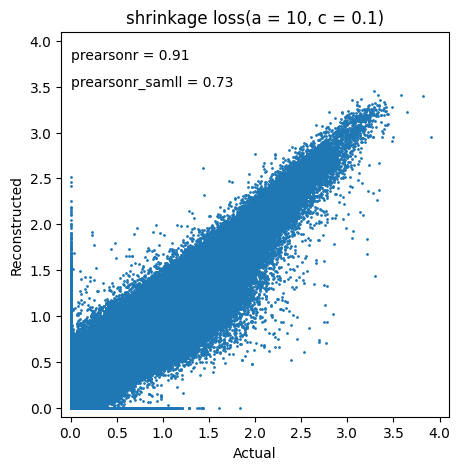

In [18]:
raw_data_flatten = np.array(data).flatten()
mod_out_skloss_flatten = out_mod_skloss.flatten()

plt.figure(figsize=(5,5))
plt.scatter(x=raw_data_flatten, y=mod_out_skloss_flatten, s=1)
plt.xlim(-0.1, 4.1)
plt.ylim(-0.1, 4.1)
plt.xlabel('Actual')
plt.ylabel('Reconstructed')
plt.text(0, 3.8, 'prearsonr = 0.91')
plt.text(0, 3.5, 'prearsonr_samll = 0.73')
plt.title('shrinkage loss(a = 10, c = 0.1)')

In [16]:
stats.pearsonr(raw_data_flatten, mod_out_skloss_flatten)

PearsonRResult(statistic=np.float64(0.9129336506345982), pvalue=np.float64(0.0))

In [17]:
stats.pearsonr(
    raw_data_flatten[raw_data_flatten < np.percentile(raw_data_flatten, 50)], 
    mod_out_skloss_flatten[raw_data_flatten < np.percentile(raw_data_flatten, 50)]
)

PearsonRResult(statistic=np.float64(0.737461167333553), pvalue=np.float64(0.0))

In [401]:
perf_alf2 = pd.read_csv('result_LA_percentile_50_alpha_2/dp1_0_dp2_0/performance_tmp.csv', index_col=0)
perf_alf2 = perf_alf2[(perf_alf2['weight_decay'] == 1e-10) & (perf_alf2['network_type']=='cpd')]
perf_alf2.index = range(perf_alf2.shape[0])

report_alf2 = perf_alf2[['weight_decay', 'drop_p_prior', 'drop_p_kki', 'cv']].drop_duplicates().copy()
report_alf2.index = range(report_alf2.shape[0])

report_alf2['AUPRC'] = 0.0
report_alf2['R2'] = 0.0
for index, row in report_alf2.iterrows():
    tmp = perf_alf2.loc[(perf_alf2['weight_decay']==row['weight_decay'])&\
                      (perf_alf2['drop_p_prior']==row['drop_p_prior'])&\
                      (perf_alf2['drop_p_kki']==row['drop_p_kki'])&\
                      (perf_alf2['cv']==row['cv'])]
    # 在每个超参数组合下，每次交叉验证中，选取fit/refit（11个）模型R2最高时的AUPRC和R2作为这个超参数组合在这次交叉验证中的性能
    max_r2_row = tmp.loc[tmp['val_r2'].idxmax()]
    report_alf2.at[index, 'AUPRC'] = max_r2_row['AUPRC']
    report_alf2.at[index, 'R2'] = max_r2_row['val_r2']

# 计算所有交叉验证的平均值代表每个超参数组合的性能
report_alf2 = report_alf2.groupby(['weight_decay', 'drop_p_prior', 'drop_p_kki'])[['AUPRC', 'R2']].mean().reset_index()

report_alf2

,weight_decay,drop_p_prior,drop_p_kki,AUPRC,R2
0,1.000000e-10,0,0,0.226938,0.861669


In [402]:
mod_model_alf2 = torch.load('result_LA_percentile_50_alpha_2/dp1_0_dp2_0/model/cv0_wd1e-10_refit9.pth')
mod_model_alf2.eval()

KinaseNet(
  (activation): ReLU0()
  (prior): Encoder(
    (dropout): Identity()
    (activation): ReLU0()
    (fc): Linear(in_features=10287, out_features=186, bias=False)
  )
  (kki): LatentLayer(
    (dropout): Identity()
    (activation): ReLU0()
    (fc): Linear(in_features=186, out_features=186, bias=False)
  )
  (ksr): Decoder(
    (dropout): Identity()
    (activation): ReLU0()
    (fc): Linear(in_features=186, out_features=10287, bias=False)
  )
)

In [403]:
out_mod_alf2 = mod_model_alf2(torch.tensor(np.array(data)).to(raw_model.prior.fc.weight.dtype)).detach().numpy()

Text(0.5, 1.0, 'alpha_samll = 2, percentile = 0.5')

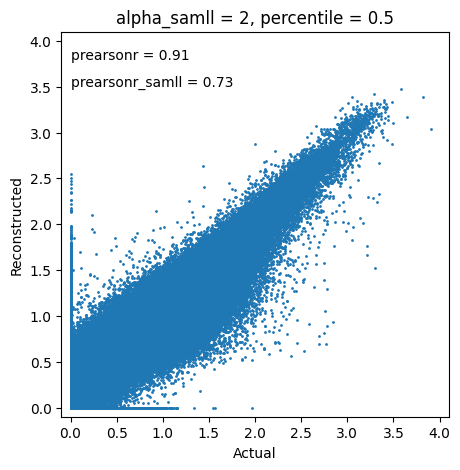

In [404]:
raw_data_flatten = np.array(data).flatten()
mod_out_alf2_flatten = out_mod_alf2.flatten()

plt.figure(figsize=(5,5))
plt.scatter(x=raw_data_flatten, y=mod_out_alf2_flatten, s=1)
plt.xlim(-0.1, 4.1)
plt.ylim(-0.1, 4.1)
plt.xlabel('Actual')
plt.ylabel('Reconstructed')
plt.text(0, 3.8, 'prearsonr = 0.91')
plt.text(0, 3.5, 'prearsonr_samll = 0.73')
plt.title('alpha_samll = 2, percentile = 0.5')

In [405]:
stats.pearsonr(raw_data_flatten, mod_out_alf2_flatten)

(0.9118034523467369, 0.0)

In [406]:
stats.pearsonr(raw_data_flatten[raw_data_flatten < np.percentile(raw_data_flatten, 50)], 
               mod_out_alf2_flatten[[raw_data_flatten < np.percentile(raw_data_flatten, 50)]])

(0.7334926601311111, 0.0)